In [77]:
from citations.CitationClassifier import CitationClassifier
from documents.Corpus import Corpus
from citations.Agglomerator import RankedClassificationCounts
from typing import List, Set
import regex as re
from config import *
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd


#markdown_path = '/Users/Alex/Library/CloudStorage/GoogleDrive-alexjfogelson@gmail.com/My Drive/FutureTech/workspace/true_urop_task2_markdown/'
markdown_path = '/Users/Alex/Desktop/paper_analysis_toolkit/data/Markdown'

In [78]:
corpus = Corpus(markdown_path, 
                    extensions = ['mmd'])

100%|██████████| 1857/1857 [00:14<00:00, 126.38it/s]


In [79]:
with open(FOUNDATION_MODELS_PATH, 'r') as f:
    foundational_models_json = json.load(f)
    keys_, titles_, ids_ = list(zip(*[(key, data['title'].replace('\\infty', '∞'), data['paperId']) for key, data in foundational_models_json.items()]))
    keys_, titles_, ids_ = list(keys_), list(titles_), list(ids_)

foundation_model_filter = [True for id in ids_]
keys, titles = np.array(keys_)[foundation_model_filter].tolist(), np.array(titles_)[foundation_model_filter].tolist()

# Classifying based on specific words

Currently looking for the following four phrases (or variations):

1) fine-tuning
2) n-shot learning
3) prompt engineering
4) chain-of-thought reasoning
5) retrieval augmented generation
   
We currently only take the top ranking example, just so we can look at some preliminary results.

In [80]:
class GranularCitationClassier(CitationClassifier):
    def __init__(self):
        pass
    
    def classify_text(self, text: str, labels: Set[str]) -> str:
        not_in_methods = labels.intersection({'background', 'result', 'introduction'})
        in_methods = 'method' in labels
        
        if not in_methods:
            return 'none'

        fine_tune = bool(re.findall(r'fine(ly)?[\-\s]?tun', text, re.IGNORECASE))
        n_shot = bool(re.findall(r'(?:few|(?<!\d)\d|\sn|one|two|three|four|five|zero)(?:\-|\s{1})shot', text, re.IGNORECASE))
        prompt = bool(re.findall(r'prompt(ing)?[\-\s]?(?:engineer|tun)', text, re.IGNORECASE))
        cot = bool(re.findall(r'chain[s]?[\-\s]?of[\-\s]?thought', text, re.IGNORECASE) + 
                    re.findall(r'(?:\s+|^)cot(?:[\.\!\?,\-\s]+|$)', text, re.IGNORECASE) +
                    re.findall(r'step[\-\s]?by[\-\s]?step( reason)?', text, re.IGNORECASE)
        )
        rag = bool(re.findall(r'(retrieval[\-\s]?(augment(?:ed)?|enhance(?:d)?|base(?:d)?)[\-\s]?generat)', text, re.IGNORECASE) + 
                re.findall(r'(?:\s+|^)rag(?:[\.\!\?,\-\s]+|$)', text, re.IGNORECASE)
                    )

        
        mapping = {'fine-tune': fine_tune, 
                'n-shot': n_shot, 
                'prompt-eng': prompt,
                'cot': cot,
                'rag': rag}
        
        for classification in self.getClassificationOrdering():
            if mapping.get(classification):
                return classification
        
        return 'none'
        
    
    def getClassificationOrdering(self) -> List[str]:
        return ['fine-tune', 'n-shot', 'prompt-eng', 'cot', 'rag', 'none']
    
    def getClassificationRanking(self, result):
        return  self.getClassificationOrdering().index(result)

In [81]:
classifier = GranularCitationClassier()

corpus.findAllPaperRefsAllTitles(titles = titles, keys = keys, classifier = classifier)


100%|██████████| 953/953 [03:16<00:00,  4.85it/s]


In [82]:
textualRefs = corpus.getAllTextualReferences(as_dict=True)

# Example Sentences Found

We want to get a sense for how good the classifications are, so some examples are given.

In [83]:
columns = ['cot', 'fine-tune', 'n-shot', 'prompt-eng', 'rag']
for column in columns:
    all_sentences = [f"SECTION LABELS: {ref['labels']}\n{ref['sentence']}" for ref in textualRefs if ref['classification'] == column]
    seperator = '\n\n' + '=' * 400 + '\n\n'
    
    content = seperator.join(all_sentences)
    
    with open(f'{column}_examples.txt', 'w') as f:
        f.write(seperator.join(all_sentences))
        


# Hist over all sentences

Looking at all textual references, we get the following distribution, ignoring NONE classifications.

(array([318.,   0., 694.,   0.,   0.,  44.,   0.,   4.,   0.,  11.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

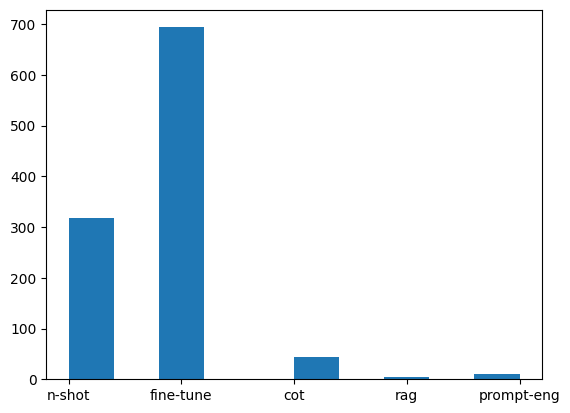

In [84]:
df = pd.DataFrame(textualRefs)
mask = (df['classification'] != 'none')
plt.hist(df[mask]['classification'])

# Merging sentences with Papers

For each paper, we take the sentence with the best ranked classification and use that for the entire paper. We then group by the foundation model, counting the number of papers with each classification. Those are the results below.

<BarContainer object of 5 artists>

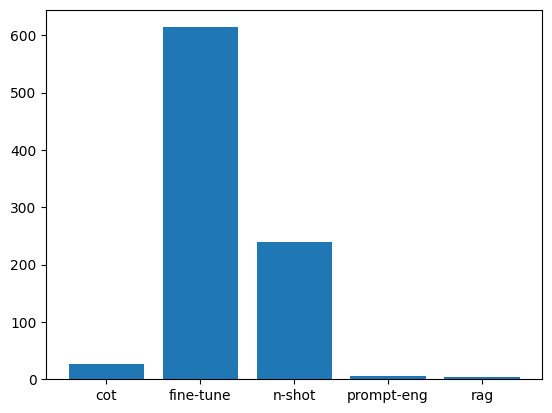

In [85]:
agglomerator = RankedClassificationCounts()
classification_counts = corpus.agglomerateAllTextualReferences(agglomerator=agglomerator)
columns = ['cot', 'fine-tune', 'n-shot', 'prompt-eng', 'rag']

total_counts = classification_counts[columns].sum(axis = 0).to_numpy()

plt.bar(columns, total_counts)

<BarContainer object of 6 artists>

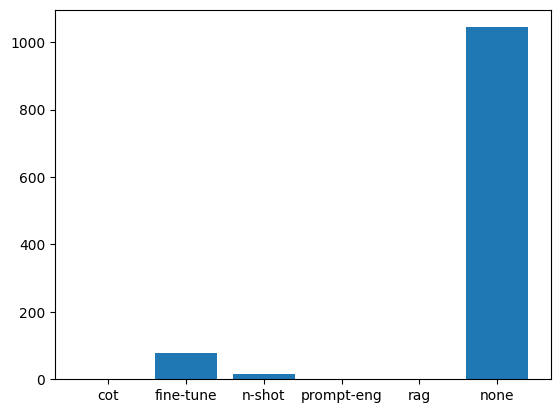

In [86]:
model_name = '64_llama-65b'
columns = ['cot', 'fine-tune', 'n-shot', 'prompt-eng', 'rag', 'none']
values = classification_counts[classification_counts['FM_key'] == model_name][columns].to_numpy()[0]
plt.bar(columns, values)

In [87]:
# one line to help find exact titles
search_term = 'llama'
list(filter(lambda s: search_term in s, classification_counts['FM_key']))

['312_llama_2-70b',
 '448_llama_2-7b',
 '482_llama-7b_(protein-oriented_instructions_finetuned)',
 '606_code_llama-34b',
 '64_llama-65b',
 '865_code_llama_70b',
 '956_llama-7b']

# Regex Testing

### Fine tuning

In [88]:
variations = ["fine-tuning","fine tuning","finetuning","fine tune","fine-tune","fine tuned","fine-tuned","finely tuned","finely-tuned","fine tunings","fine-tunings","fine tunes","fine-tunes","fine tuner","fine-tuner","fine tuners","fine-tuners"]

matched = list(filter(None, map(lambda text: 
                                        re.findall(r'fine(ly)?[\-\s]?tun', text, re.IGNORECASE),                                    
                                        variations)))

unmatched = [variation for variation, matches in zip(variations, matched) if not matches]

assert(len(unmatched) == 0), unmatched


### Few shot

In [89]:
variations = ['few-shot', 'Few-shot', 'few shot', 'Few Shot', '1-shot', 'one-shot', 'One-shot', 'one shot', 'One Shot', '2-shot', 'two-shot', 'Two-shot', 'two shot', 'Two Shot', '3-shot', 'three-shot', 'Three-shot', 'three shot', 'Three Shot', '4-shot', 'four-shot', 'Four-shot', 'four shot', 'Four Shot', '5-shot', 'five-shot', 'Five-shot', 'five shot', 'Five Shot', '0-shot', 'zero-shot', 'Zero-shot', 'zero shot', 'Zero Shot']

matched = list(map(lambda text: 
                re.findall(r'(?:few|(?<!\d)\d|\sn|one|two|three|four|five|zero)(?:\-|\s{1})shot', text, re.IGNORECASE),
                variations
))

unmatched = [variation for variation, matches in zip(variations, matched) if not matches]

assert(len(unmatched) == 0), unmatched

### Prompt Engineering

In [90]:
variations = ["prompt engineering","prompt-engineering","promptengineering","prompt engineer","prompt-engineer","promptengineer","prompt engineered","prompt-engineered","promptengineered","prompt engineers","prompt-engineers","promptengineers","prompting engineer","prompting-engineer","promptingengineer","prompting engineering","prompting-engineering","promptingengineering"]
matched = list(map(lambda text: 
                re.findall(r'prompt(ing)?[\-\s]?(?:engineer|tun)', text, re.IGNORECASE),    
                variations))

unmatched = [variation for variation, matches in zip(variations, matched) if not matches]

assert(len(unmatched) == 0), unmatched

### Chain of Thought

In [91]:
variations = ['cot','cOt','CoT','COT','chain of thought','Chain of Thought','chain-of-thought','Chain-of-Thought','step-by-step reasoning', 'Step-by-Step Reasoning','step by step reasoning','Step by Step Reasoning']

matched = list(map(lambda text: 
                re.findall(r'chain[s]?[\-\s]?of[\-\s]?thought', text, re.IGNORECASE) + 
                re.findall(r'(?:\s+|^)cot(?:[\.\!\?,\-\s]+|$)', text, re.IGNORECASE) +
                re.findall(r'step[\-\s]?by[\-\s]?step( reason)?', text, re.IGNORECASE),
               variations
))

unmatched = [variation for variation, matches in zip(variations, matched) if not matches]

assert(len(unmatched) == 0), unmatched

### RAG

In [92]:
variations = ['retrieval augmented generation', 'Retrieval Augmented Generation', 'retrieval-augmented generation', 'Retrieval-Augmented Generation', 'retrieval augmented generations', 'Retrieval Augmented Generations', 'retrieval-augmented generations', 'Retrieval-Augmented Generations', 'retrieval enhanced generation', 'Retrieval Enhanced Generation', 'retrieval-enhanced generation', 'Retrieval-Enhanced Generation', 'retrieval enhanced generations', 'Retrieval Enhanced Generations', 'retrieval-enhanced generations', 'Retrieval-Enhanced Generations', 'retrieval-based generation', 'Retrieval-Based Generation', 'retrieval based generation', 'Retrieval Based Generation', 'retrieval-based generations', 'Retrieval-Based Generations', 'retrieval based generations', 'Retrieval Based Generations', 'RAG', 'rag', 'Rag', 'rag-based', 'rag is']

matched = list(map(lambda text: 
                re.findall(r'(retrieval[\-\s]?(augment(?:ed)?|enhance(?:d)?|base(?:d)?)[\-\s]?generat)', text, re.IGNORECASE) + 
                re.findall(r'(?:\s+|^)rag(?:[\.\!\?,\-\s]+|$)', text, re.IGNORECASE)
                ,
                variations
))

unmatched = [variation for variation, matches in zip(variations, matched) if not matches]

assert(len(unmatched) == 0), unmatched


## Single Sentence Classification

Helpful for looking at single sentences

In [93]:
text = 'we adopt two typical models for both types and a state-of-art system action prediction method, co-gen [70]: (i) following [25],[34],[67], we construct a multi-label classification model by using a bert encoder to encode the context and feeding the [cls] token on an mlp followed by sigmoid activation function to perform binary classification for each action; (ii) following [28],[34],<cite>[52]</cite>,[63], we construct a sequence generation model by using bert to encode the context and feeding the [cls] token to a gru decoder to sequentially decode actions step by step; and (iii) co-gen is a sequence generation model, and we use co-gen (action prediction) (see section 5) to generate actions.'
classification = GranularCitationClassier().classify_text(text = text, labels = {'method'})
classification

'cot'

## In case of emergency

If we have to restart the notebook, we don't want to wait for it to classify everything again.

In [94]:
with open('pickle/corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [95]:
with open('pickle/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)